# Assignment 2 - Question 3
The objective of this assignment is to get you familiarize with  the  problem  of  `Dimensionality Reduction`.

## Instructions
- Write your code and analysis in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of other cells.
- No inbuilt functions to be used until specified. Libraries allowed (Numpy, matplotlib)

## Datasets 
- The IIIT-CFW is database for the cartoon faces in the wild. The dataset contains 8928 annotated cartoon faces of famous personalities of the world with varying profession. Additional 1000 real faces of the public figure to study cross modal retrieval tasks, such as, Photo2Cartoon retrieval. Ref - https://cvit.iiit.ac.in/research/projects/cvit-projects/cartoonfaces
- We have sub sampled the following data for this assignment - Cartoon faces of 8 subjects and approx. 100 images for each subject. 

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>_Assignment2_Q3.ipynb`.

In [19]:
# Installing Pillow Libraries
!pip install scikit-learn matplotlib Pillow

In [20]:
import numpy as np
import os
from random import randrange
from matplotlib import pyplot as plt
from PIL import Image

## Load Data

In [21]:
cfw_dict = {
    'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7
}

opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

In [22]:
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

def display_images(imgs,classes,row=1,col=2,w=32,h=32):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

def load_data(dir_path):
    image_list = []
    y_list = []
    label_dict = cfw_dict
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue
    image_list = np.array(image_list)
    y_list = np.array(y_list)
    print("Dataset shape:",image_list.shape)
    print("Label shape:",y_list.shape)

    return image_list,y_list

In [23]:
dirpath = './IIIT-CFW/'
X,y = load_data(dirpath)

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)


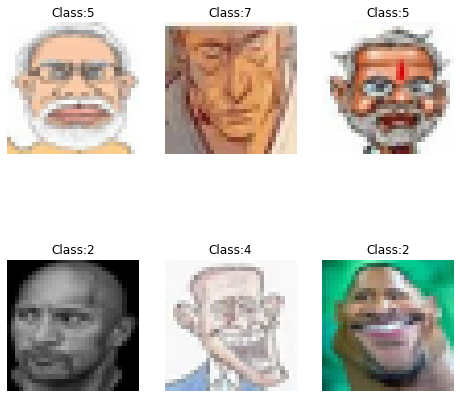

In [24]:
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

ind = np.random.randint(0,y.shape[0],6)
display_images(X[ind,...],y[ind], row=2,col=3)

## Dimensionality Reduction
- Plot eigen spectrum for the data.

Percentage of variance preserved is defined as the fraction of eigen values used. As we include more principal components to describe the data, the percentage of variances preserved under the dimensionality reduction increases. 

- Plot the percentage of variances vs the number of principal components to validate the above statement.
- Try visualizing these eigen vectors. Comment on what these ghost faces represent 
- Try reconstructing images with your choice of number of principal components and visualize the reconstructed image.

Let's define reconstruction error as the frobenius norm of the difference between original and reconstructed image. 

- Plot the number of principal components vs the corresponding reconstruction error for 5 selected number of principal components of your choice.
- Using the two dominant principal values, plot the data with colors showing the labels. What do you observe?


#### Write a function that gives eigen values and eigen vectors given data

In [25]:
# write function
from numpy.linalg import eig

def findEigens(mat):
  values, vectors = eig(mat)
  return values,vectors

#### Compute eigen values and plot eigen value spectrum

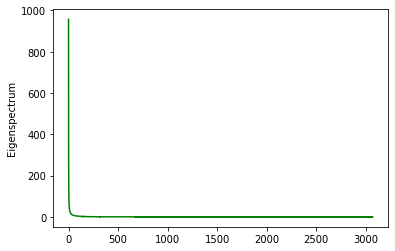

In [26]:
# eigen values and spectrum
from numpy import cov

X = X.reshape((N,W*H*C))
X = np.array(X)
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(X)
# print(standardized_data.shape)
sample_data = standardized_data
Cv = cov(sample_data, rowvar=False)
eigenvalues,eigenvector = findEigens(Cv)
idx = eigenvalues.argsort()

plt.plot(idx,eigenvalues[idx].real ,color='green')
plt.ylabel('Eigenspectrum')
plt.show()

#### Plot the percentage of variances vs the number of principal components

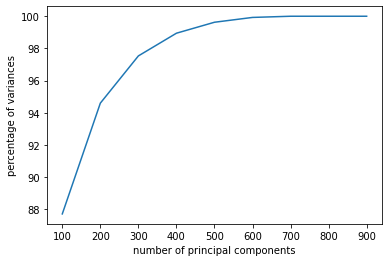

In [27]:
# plot variance vs components

prc_comps = [int(i) for i in range(100,1000,100)]
per_var = list()

sorted_index = np.argsort(eigenvalues)[::-1]
sorted_eigenvalue = eigenvalues[sorted_index]
sorted_eigenvector = eigenvector[:,sorted_index]

sorted_eigenvector = sorted_eigenvector.real
sorted_eigenvalue = sorted_eigenvalue.real

for k in prc_comps:
  per_var.append((np.sum(sorted_eigenvalue[0:k])/np.sum(sorted_eigenvalue))*100)

plt.plot(prc_comps, per_var)

plt.xlabel('number of principal components')

plt.ylabel('percentage of variances')
 
plt.show()

#### Visualize eigen faces(eigen vectors)

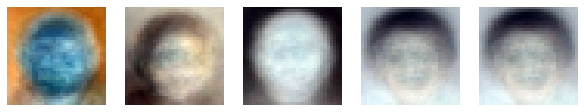

In [28]:
# """
# Use the below sample code to visualize the eigen faces and reconstructed images (can write your own function as well)

def plot(image,H,W,C,indices):
    #indices = [randrange(100)+1 for i in range(5)]
    pl = np.reshape(image.T, (-1,H,W,C))
    plt.figure(figsize=(25,25))
    for c,i in enumerate(indices):
        ele = pl[i]
        minim = np.min(ele)
        maxim = np.max(ele)
        ele = (ele - minim) / (maxim - minim)
        ele = np.clip(ele,0,254)
        plt.subplot(1,12,c+1)
        plt.axis('off')
        plt.imshow(ele,cmap=plt.cm.gray)
    plt.show()

indices = [randrange(12)+1 for i in range(5)]
# print(type(sorted_eigenvector[0][0]))
plot(sorted_eigenvector.real,H,W,C,indices)

#### Reconstruction 

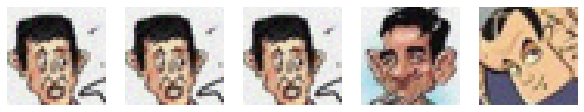

In [29]:
# reconstruction

def plotReconstruction(eigenvector_subset,H,W,C,indices):
    x_reduced = np.dot(eigenvector_subset.transpose(),X.transpose()).transpose()
    x_reduced = x_reduced.real
    plt.figure(figsize=(25,25))
    for c,i in enumerate(indices):
        ele = np.matmul(eigenvector_subset,x_reduced[i])
        ele = np.reshape(ele, (H,W,C))
        minim = np.min(ele)
        maxim = np.max(ele)
        ele = (ele - minim) / (maxim - minim)
        ele = np.clip(ele,0,254)
        plt.subplot(1,12,c+1)
        plt.axis('off')
        plt.imshow(ele,cmap=plt.cm.gray)
    plt.show()

n_components = 200
eigenvector_subset = sorted_eigenvector[:,0:n_components]
indices = [randrange(12)+1 for i in range(5)]

plotReconstruction(sorted_eigenvector.real,H,W,C,indices)

#### Plot data in 2D

In [30]:
X_cov = cov(X,rowvar=False)
eig_values,eig_vector = findEigens(X_cov)

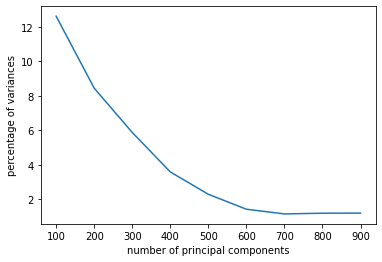

In [31]:
#Plot the number of principal components vs the corresponding reconstruction error for 5 selected number of principal components of your choice.
def forbenius(eigenvector_subset,H,W,C,indices):
    x_reduced = np.dot(eigenvector_subset.transpose(),X.transpose()).transpose()
    x_reduced = x_reduced.real
    diff_mat = list()
    for c,i in enumerate(indices):
        ele_rec =  np.matmul(eigenvector_subset,x_reduced[i])
        ele_org = X[i]
        diff_mat.append(ele_org-ele_rec)
    diff_mat = np.array(diff_mat)
    return np.linalg.norm(diff_mat,ord='fro')
        
   
prnc_comps = [int(i) for i in range(100,1000,100)]
recons_error = list()

sorted_index = np.argsort(eig_values)[::-1]
sorted_eigenvalue = eigenvalues[sorted_index]
sorted_eigenvector = eig_vector[:,sorted_index]
sorted_eigenvector = sorted_eigenvector.real
sorted_eigenvalue = sorted_eigenvalue.real

for pcomps in prnc_comps:
  sorted_subvector = sorted_eigenvector[:,0:pcomps]
  indices = [randrange(12)+1 for i in range(5)]
  recons_error.append(forbenius(sorted_subvector,H,W,C,indices))


plt.plot(prnc_comps, recons_error)
plt.xlabel('number of principal components')
plt.ylabel('reconstruction error')
plt.show()

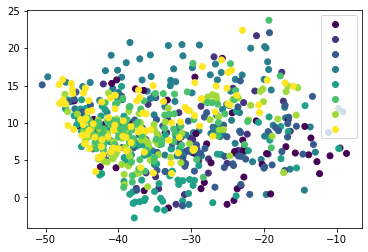

In [32]:
# plot data in 2D
n_components = 2
eigenvector_subset2 = sorted_eigenvector[:,0:n_components]
Xt = np.matmul(X,eigenvector_subset2)
plot = plt.scatter(Xt[:,0], Xt[:,1], c=y)
plt.legend(handles=plot.legend_elements()[0])
plt.show()

## Lets analyze the principal components classwise
- Visualize dominant eigen faces of each of the classes.
- Print the number of principal components required to retain 90% variance for each of the classes and for the entire dataset
- Are the number of components same for entire dataset and each of the classes. If yes why? If not why?

Example output:
```
Number of principal components required for 90% reconstruction of the:
Entire Dataset = 10 
Amitabhbachan = 10
AamirKhan = 10
...
```

In [33]:
# Load data again
X,y = load_data(dirpath)

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)


#### Visualize dominant eigen faces of each of the classes

In [34]:
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((X.shape[0],-1))

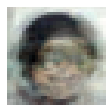

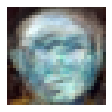

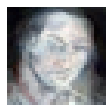

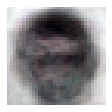

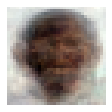

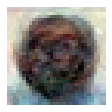

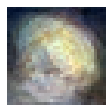

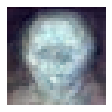

In [35]:
# visualize
from sklearn.preprocessing import StandardScaler
from numpy import cov
from numpy.linalg import eig

def Visualize_dominant_eigen_faces(X_cls):
  scal_data = StandardScaler().fit_transform(X_cls)
  Cv = cov(scal_data, rowvar=False)
  eigenvalues,eigenvector = eig(Cv)
  sorted_index = np.argsort(eigenvalues)[::-1]
  sorted_eigenvalue = eigenvalues[sorted_index]
  sorted_eigenvector = eigenvector[:,sorted_index]
  sorted_eigenvector = sorted_eigenvector.real
  sorted_eigenvalue = sorted_eigenvalue.real
  return sorted_eigenvalue,sorted_eigenvector
  

X_class = dict()
total_class = np.max(y)+1
for clas in range(total_class):
  X_class[clas] = list()
for xi in range(N):
  X_class[y[xi]].append(list(X[xi]))
eigens_class = dict()
for classs in X_class:
  sorted_eigenvalue,sorted_eigenvector = Visualize_dominant_eigen_faces(np.asarray(X_class[classs]))
  eigens_class[classs] = sorted_eigenvalue
  pl = np.reshape(sorted_eigenvector.T, (-1,H,W,C))
  plt.figure(figsize=(25,25))
  ele = pl[1]
  minim = np.min(ele)
  maxim = np.max(ele)
  ele = (ele - minim) / (maxim - minim)
  ele = np.clip(ele,0,254)
  plt.subplot(1,12,1)
  plt.axis('off')
  plt.imshow(ele,cmap=plt.cm.gray)
  plt.show()


#### Number of principal components required to retain 90% variance for each of the classes and for the entire dataset

In [36]:
# components required
rev_cfw = dict()
for figure in cfw_dict:
  rev_cfw[cfw_dict[figure]] = figure
pc = int(W*H*C)

print("Number of principal components required for 90% reconstruction of the:")
e_val,e_vec = Visualize_dominant_eigen_faces(X)
temp = np.sum(e_val)
for j in range(1,pc):
  if ((np.sum(e_val[0:j])/temp)*100) >= 90:
    print("For entire dataset =",j)
    break
for classs in eigens_class:
  vector = np.asarray(eigens_class[classs])
  temp = np.sum(vector)
  for j in range(1,pc):
    if ((np.sum(vector[0:j])/temp)*100) >= 90:
      print(rev_cfw[classs],"=",j)
      break
  




Number of principal components required for 90% reconstruction of the:
For entire dataset = 124
Amitabhbachan = 22
AamirKhan = 25
DwayneJohnson = 29
AishwaryaRai = 38
BarackObama = 45
NarendraModi = 59
ManmohanSingh = 53
VladimirPutin = 48


#### Analysis : Are the number of components same for entire dataset and each of the classes. If yes why? If not why?

In [ ]:
# observation/analysis

The number of principle components are required to reatain 90% variance for each class is slighlty differ from each other but there is huge differnce for the entire dataset. That has been proved from below cell output.So,the number of components are different for entire dataset and each of the classes. The main reason is the size of each dataset is different from each other.

---



## Linear Regression (continued)
1. Perform linear regression on below datapoints
2. Use PCA for dimensionality reduction on this datapoints and then perform Linear regression.
3. Perform this experiment on different number of components and report the score for linear regression. Plot the graph of [1-200] principal components vs regression score. What do you observe?

Note :- Can use inbuilt functions for Linear Regression and PCA for this question

From the below graph we can see that R2 score is linearly increasing with the number of components upto some limit and after a limit R2 score is fluctuating between the value of 0.35 to 0.45. But again after some value of k, R2 score is decreasing with the increasing of k.  
A high or low R-square isn't necessarily good or bad, as it doesn't convey the reliability of the model, nor whether you've chosen the right regression.

In [37]:
# datapoints
X,_= load_data(dirpath)
X = X.reshape((X.shape[0],-1))
label = np.array([randrange((32*32*3)) for i in range(5)])
label = np.mean(X[:,label], axis = 1)
print(label.shape)

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)
(672,)


In [38]:
# code here
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score

sc = StandardScaler()
X_scaled = sc.fit_transform(X)

def find_RMSE_LG(n_components):
  pca = PCA(n_components=n_components)
  X_pca = pca.fit_transform(X_scaled)
  X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, _, test_size=0.20, shuffle=True, random_state=2)
  clf = LinearRegression()
  clf.fit(X_train_pca, y_train)
  y_pred = clf.predict(X_test_pca) # Predictions
  y_true = y_test # True values
  
  return r2_score(y_true, y_pred)


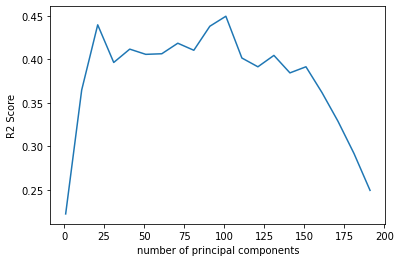

In [39]:
# analysis / plot (split the cells if required)
comp = [int(i) for i in range(1,200,10)]
r2score = list()
for p_comp in comp:
  r2score.append(find_RMSE_LG(p_comp))

plt.plot(comp, r2score)
plt.xlabel('number of principal components')
plt.ylabel('R2 Score')
plt.show()